In [62]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal, Annotated
from langchain_oci import ChatOCIGenAI
from langchain_core.messages import SystemMessage,HumanMessage
from dotenv import load_dotenv
import operator,os

In [63]:
load_dotenv()
service_endpoint = os.getenv("OCI_SERVICE_ENDPOINT")
compartment_id = os.getenv("OCI_COMPARTMENT_ID")
model_id = os.getenv("OCI_MODEL_ID")
tweet_model_id=os.getenv("OCi_MODEL_ID_GENERATE_TWEET")

evaluator_llm = ChatOCIGenAI(
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_id=model_id,
)
generator_llm=ChatOCIGenAI(
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_id=model_id,
)
optimizer_llm=ChatOCIGenAI(
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_id=tweet_model_id,
)

In [64]:
from pydantic import BaseModel, Field
class TweetEvaluation(BaseModel):
    evaluation: Literal["approved","need_improvement"] = Field(..., description="Final evaluation result")
    feedback: str =Field(..., description="feedback for the tweet")

In [65]:
structured_evaluator_llm=evaluator_llm.with_structured_output(TweetEvaluation)

In [66]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved","need_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]
    

In [67]:
def generate_tweet(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    
    response=generator_llm.invoke(messages).content
    
    return {'tweet':response,'tweet_history':[response]}
    

In [68]:
def evaluate_tweet(state: TweetState):
    #prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "need_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    
    response=structured_evaluator_llm.invoke(messages)
    print(response)
    return {'evaluation':response.evaluation, 'feedback': response.feedback,'feedback_history': [response.feedback]}

In [69]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [70]:
def route_evaluation(state: TweetState):
    if state['evaluation']== 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'need_improvement'

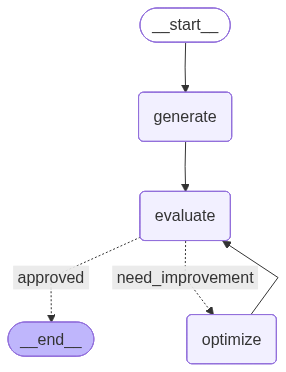

In [71]:
graph=StateGraph(TweetState)

#add nodes
graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

#add edges
graph.add_edge(START,'generate')
graph.add_edge('generate','evaluate')
#graph.add_conditional_edges(src, routing_function, {True: "node_b", False: "node_c"})
graph.add_conditional_edges('evaluate',route_evaluation,{'approved':END,'need_improvement':'optimize'})
graph.add_edge('optimize','evaluate')

workflow=graph.compile()

workflow

In [72]:
initial_state = {
    "topic": "civic sense in India",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

evaluation='approved' feedback='Relatable, vivid, and culturally specific with a clean “starter pack” cadence; the “indicator as Diwali decor” and “#SwachhSelfie/Avengers” closer are sharp. It’s comfortably under 280 and not a setup-punchline. That said, it leans on well-worn tropes (helmet-on-elbow, horn-as-language), and the list runs a touch long, softening the snap. Trim one or two beats and tighten phrasing (“high beams at noon,” “dustbin beside the pile”) to up punchiness and shareability. Still likely to travel on Indian Twitter due to high relatability.'


In [73]:
result

{'topic': 'civic sense in India',
 'tweet': 'Our civic sense in India starter pack: helmet on elbow, high-beam in daylight, indicator as Diwali decor, horn as love language, zebra crossing as wall art, dustbin as landmark next to the actual pile. Then we upload a #SwachhSelfie and feel like the Avengers.',
 'evaluation': 'approved',
 'feedback': 'Relatable, vivid, and culturally specific with a clean “starter pack” cadence; the “indicator as Diwali decor” and “#SwachhSelfie/Avengers” closer are sharp. It’s comfortably under 280 and not a setup-punchline. That said, it leans on well-worn tropes (helmet-on-elbow, horn-as-language), and the list runs a touch long, softening the snap. Trim one or two beats and tighten phrasing (“high beams at noon,” “dustbin beside the pile”) to up punchiness and shareability. Still likely to travel on Indian Twitter due to high relatability.',
 'iteration': 1,
 'max_iteration': 5,
 'tweet_history': ['Our civic sense in India starter pack: helmet on elbow,